In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import time
import gc
import scipy
from scipy.signal import butter, filtfilt, argrelextrema
from scipy.interpolate import interp1d
from tqdm import tqdm

In [5]:

# improve the ploting style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 22
rcParams['mathtext.fontset'] = 'stix'

In [6]:
# transform_data = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.RandomCrop(32,padding=4),
#     # transforms.RandomRotation(40)
#     transforms.Lambda(lambda x : x + 0.5*torch.rand_like(x)),
#     transforms.Lambda(lambda x: x.clamp(0,1)),
#     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Apply the (x - mean)/var operation on the components of the data # if x is in [0,1] then Normalise(x) is in [-1,1] # is applied on the three channels RGB
# ])

# # Data import
# dtype = torch.float32
# trainset = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('train',transform = transform_data),  batch_size = 1)
# validset = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('valid', transform = transform_data), batch_size = 1)
# testset = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('test', transform = transform_data), batch_size = 1)

# # Data conversion to tensors
# x_train = []
# y_train = []
# x_valid = []
# y_valid = []
# x_test = []
# y_test = []
# for x, y in tqdm(trainset, desc="Chargement train"):
#     x_train.append(x)
#     y_train.append(y)
# for x, y in tqdm(validset, desc="Chargement train"):
#     x_valid.append(x)
#     y_valid.append(y)
# for x, y in tqdm(testset, desc="Chargement train"):
#     x_test.append(x)
#     y_test.append(y)

# x_train = torch.squeeze(torch.tensor(np.array(x_train)))
# y_train = torch.squeeze(torch.tensor(np.array(y_train)))
# x_valid = torch.squeeze(torch.tensor(np.array(x_valid)))
# y_valid = torch.squeeze(torch.tensor(np.array(y_valid)))
# x_test = torch.squeeze(torch.tensor(np.array(x_test)))
# y_test = torch.squeeze(torch.tensor(np.array(y_test)))

# # Saving datas to tensors
# torch.save({'inputs' : x_train, 'targets' : y_train}, 'datas/CINIC-10_trainset_noised.pt')
# torch.save({'inputs' : x_valid, 'targets' : y_valid}, 'datas/CINIC-10_validset_noised.pt')
# torch.save({'inputs' : x_test, 'targets' : y_test}, 'datas/CINIC-10_testset_noised.pt')

torch.Size([180000, 32, 32, 3]) torch.Size([180000]) torch.Size([90000, 32, 32, 3]) torch.Size([90000])
torch.Size([180000, 10]) torch.Size([90000, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.77254903].
Clipping i

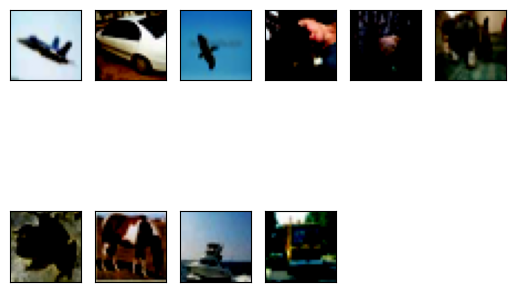

torch.Size([72000, 32, 32, 3]) torch.Size([72000, 1]) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]) torch.Size([36000, 32, 32, 3]) torch.Size([36000, 1])


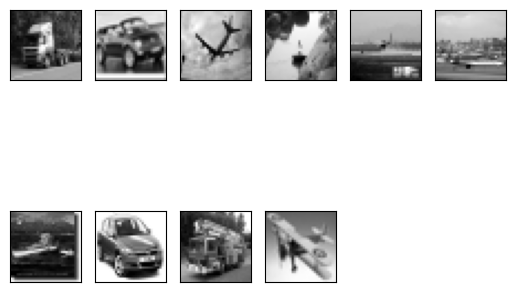

torch.Size([72000, 1024]) torch.Size([36000, 1024])


In [7]:
dtype = torch.float32

x_train, y_train_raw = torch.load('datas/CINIC-10_trainset.pt')['inputs'], torch.load('datas/CINIC-10_trainset.pt')['targets']
x_valid, y_valid_raw = torch.load('datas/CINIC-10_validset.pt')['inputs'], torch.load('datas/CINIC-10_validset.pt')['targets']
x_test, y_test = torch.load('datas/CINIC-10_testset.pt')['inputs'], torch.load('datas/CINIC-10_testset.pt')['targets']

# x_train_rotated, y_train_raw_rotated = torch.load('datas/CINIC-10_trainset_rotated.pt')['inputs'], torch.load('datas/CINIC-10_trainset_rotated.pt')['targets']
# x_valid_rotated, y_valid_raw_rotated = torch.load('datas/CINIC-10_validset_rotated.pt')['inputs'], torch.load('datas/CINIC-10_validset_rotated.pt')['targets']
# x_test_rotated, y_test_rotated = torch.load('datas/CINIC-10_testset_rotated.pt')['inputs'], torch.load('datas/CINIC-10_testset_rotated.pt')['targets']

# x_train_noised, y_train_raw_noised = torch.load('datas/CINIC-10_trainset_noised.pt')['inputs'], torch.load('datas/CINIC-10_trainset_noised.pt')['targets']
# x_valid_noised, y_valid_raw_noised = torch.load('datas/CINIC-10_validset_noised.pt')['inputs'], torch.load('datas/CINIC-10_validset_noised.pt')['targets']
# x_test_noised, y_test_noised = torch.load('datas/CINIC-10_testset_noised.pt')['inputs'], torch.load('datas/CINIC-10_testset_noised.pt')['targets']


x_train, y_train_raw = torch.cat((x_train, x_test), dim=0).permute(0,2,3,1), torch.cat((y_train_raw, y_test), dim=0)
# x_train, y_train_raw = torch.cat((x_train, x_test, x_train_rotated, x_test_rotated), dim=0).permute(0,2,3,1), torch.cat((y_train_raw, y_test, y_train_raw_rotated, y_test_rotated), dim=0)
# x_train, y_train_raw = torch.cat((x_train, x_test, x_train_rotated, x_test_rotated, x_train_noised, x_test_noised), dim=0).permute(0,2,3,1), torch.cat((y_train_raw, y_test, y_train_raw_rotated, y_test_rotated, y_train_raw_noised, y_test_noised), dim=0)


x_valid = x_valid.permute(0,2,3,1)
print(x_train.shape, y_train_raw.shape, x_valid.shape, y_valid_raw.shape)


# Modification du format des données shape (n_data,1) -> (n_data, n_classes)
y_train = torch.zeros((y_train_raw.shape[0], int(torch.max(y_train_raw)+1)))
for i, y in enumerate(y_train_raw):
    j = int(y.item())
    y_train[i,j] = 1

y_valid = torch.zeros((y_valid_raw.shape[0], int(torch.max(y_valid_raw)+1)))
for i,y in enumerate(y_valid_raw):
    j = int(y.item())
    y_valid[i,j] = 1 
print(y_train.shape, y_valid.shape)

# Binary reduction of the classes # To avoid using softmax, we regroup classes in two classes
class_binary_reduction = True
determination_des_classes = True
black_and_white_images = True

if class_binary_reduction :
    if determination_des_classes :
        # Determination des classes
        class_list = []
        class_index = 0
        for i in range (x_train.shape[0]):
            if y_train[i, class_index] == 1:
                class_list.append(x_train[i])
                class_index += 1
            if len(class_list) == len(y_train[0]):
                break
        for i, image in enumerate(class_list):
            plt.subplot(2, int(len(class_list)/2+1),i+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
        plt.show()
                
    # classe1 = [0, 1, 8, 9]  # vehicles
    # classe2 = [2, 3, 4, 5]  # animals
    
    # classe1 = [1, 3, 4]  # elk, truck, dog
    # classe2 = [5, 7, 9]  # horse, car, cat

    classe1 = [1, 9]  # car
    classe2 = [0, 8]  # truck
    
    # Création des masques pour les échantillons appartenant à ces classes
    mask_classe1_train = y_train[:, classe1].sum(dim=1) > 0  # True si appartient à classe1
    mask_classe2_train = y_train[:, classe2].sum(dim=1) > 0  # True si appartient à classe2
    
    mask_classe1_valid = y_valid[:, classe1].sum(dim=1) > 0
    mask_classe2_valid = y_valid[:, classe2].sum(dim=1) > 0
    
    # Filtrage des exemples concernés
    mask_train = torch.logical_or(mask_classe1_train, mask_classe2_train)
    mask_valid = torch.logical_or(mask_classe1_valid, mask_classe2_valid)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid]

    # Création du vecteur de labels binaires (1 pour classe1, 0 pour classe2)
    y_train = (y_train[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    y_valid = (y_valid[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)

    print(x_train.shape, y_train.shape, y_train[0:10], x_valid.shape, y_valid.shape)

if black_and_white_images :
    x_train = 0.299*x_train[:,:,:,0] + 0.587*x_train[:,:,:,1] + 0.114*x_train[:,:,:,2]
    x_valid = 0.299*x_valid[:,:,:,0] + 0.587*x_valid[:,:,:,1] + 0.114*x_valid[:,:,:,2]
    for i, image in enumerate(x_train[torch.randperm(x_train.shape[0])[:10]]):
        plt.subplot(2, int(len(x_train[0:10])/2+1),i+1)
        plt.imshow(image, cmap = 'grey')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]).to(dtype)
    print(x_train.shape, x_valid.shape)

else :    
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]*x_valid.shape[3]).to(dtype)
    print(x_train.shape, x_valid.shape)

In [8]:
dtype = torch.float32

if torch.backends.mps.is_available():
    device = torch.device("mps")
else :
    device = torch.device("cpu")
print("Computing on : ", device)

def ReLU(x):
    return torch.max(torch.tensor(0).to(device),x)

def ReLU_derivative(x):
    return (x>0).type(dtype).to(device)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    s = s.to(device)
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype).to(device) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def sigmoid_derivative(x):
    return torch.exp(-x)/((1 + torch.exp(-x))**2)

def tanh_derivative(x):
    return (1 - (torch.tanh(x)**2)).to(device)

class two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output); grad_z2  = grad_z2.to(dtype) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
   
class three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, number_of_classes,lr=0.01, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(number_of_classes, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t()
        output = self.softmax(z3) # output layer # shape (n_data, number_of_classes)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = (torch.einsum('no,noz->nz',grad_output,softmax_derivative(output))).to(dtype) # shape (n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done"

class binary_classification_two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(binary_classification_two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(1, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1 = 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1/(1 - dropout_rate)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = torch.sigmoid(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True, dropout_rate = 0):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate = " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) + ' - observation rate = ' + str(observation_rate) + ' - Train layer 1 = ' + str(train_layer_1) + ' - Train layer 2 = ' + str(train_layer_2) + ' - Dropout rate = ' + str(dropout_rate)
        self.lr = torch.tensor(lr)
        self.lr_decay_rate = torch.tensor(lr_decay_rate)
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                print("Output", output[20:22])
                training_loss = torch.mean(0.5*(output - y_minibatch)**2)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = grad_output*sigmoid_derivative(z2); grad_z2  = grad_z2.to(dtype) # shape(n_data, 1)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # if i == 250:
            #     break

            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
    
class binary_classification_three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, lr=0.01, lr_decay_rate = 1e9, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, dropout_rate = 0):
        """
        Constructor of the three-layer neural network class.
        """
        super(binary_classification_three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(1, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_2 = ((torch.rand((x.shape[0], self.hidden_2_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1, dropout_mask_2 = 1, 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2)*dropout_mask_2 # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, 1)
        output = sigmoid(z3) # output layer # shape (n_data, 1)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = torch.tensor(lr)
        self.decay_rate = lr_decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = ((torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)).to(device)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = grad_output*sigmoid_derivative(z3).to(dtype) # shape (n_data, 1) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
            
            # if i == 12000:
            #     break
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done" 

class binary_classification_four_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, hidden_3_size, lr=0.01, lr_decay_rate = 1e9, reg1 =0, reg2 = 0, reg3=0, eps_init=1, fraction_batch=0.01, observation_rate = 10, dropout_rate = 0):
        """
        Constructor of the four-layer neural network class.
        """
        super(binary_classification_four_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.hidden_3_size = hidden_3_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(hidden_3_size, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.W4 = eps_init*torch.randn(1, hidden_3_size, dtype = dtype) / np.sqrt(hidden_3_size)
        
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(hidden_3_size, 1, dtype=dtype)-1)
        self.b4 = eps_init*(2*torch.rand(1, 1, dtype = dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.W4 = self.W4.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        self.b4 = self.b4.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_2 = ((torch.rand((x.shape[0], self.hidden_2_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_3 = ((torch.rand((x.shape[0], self.hidden_3_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1, dropout_mask_2, dropout_mask_3 = 1, 1, 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2)*dropout_mask_2 # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, hidden_3_size)
        h3 = ReLU(z3)*dropout_mask_3 # hidden neurons layer_3
        z4 = (torch.mm(self.W4, z3.t()) + self.b4).t() # shape (n_data,1)
        output = sigmoid(z4) # output layer # shape (n_data, 1)
        return output, z4, h3, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, reg3 = 0, reg4 =0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, train_layer_4 = True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - Training fourth layer = " + str(train_layer_4) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) + " - dropout rate = " + str(dropout_rate)
        self.lr = torch.tensor(lr)
        self.decay_rate = lr_decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.reg4 = reg4
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = ((torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)).to(device)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z4, h3, z3, h2, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)  # shape (n_data, 1)
            grad_z4 = grad_output*sigmoid_derivative(z4).to(dtype)  # shape (n_data, 1)
            grad_h3 = (torch.mm(grad_z4, self.W4)).to(dtype)  # shape (n_data, hidden_3_size)
            grad_z3 = grad_h3*sigmoid_derivative(z3).to(dtype) # shape (n_data, hidden_3_size) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            grad_W4 = (torch.mm(grad_z4.t(),h3)/x_minibatch.shape[0]).to(dtype)
            
            grad_b4 = (torch.mean(grad_z4, dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_4:
                self.W4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_W4/(eps_init**2) + self.reg4*self.W4)).to(dtype)
                self.b4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_b4/(eps_init**2) + self.reg4*self.b4)).to(dtype)
            del x_minibatch, y_minibatch, output, z4, h3, z3, h2, z2, h1, z1, grad_output, grad_z4, grad_h3, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done" 
    
    
class binary_classification_five_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, hidden_3_size, hidden_4_size, lr=0.01, lr_decay_rate = 1e9, reg1=0, reg2=0, reg3=0, reg4=0, reg5=0, eps_init=1, fraction_batch=0.01, observation_rate = 10, dropout_rate = 0):
        """
        Constructor of the five-layer neural network class.
        """
        super(binary_classification_five_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.hidden_3_size = hidden_3_size
        self.hidden_4_size = hidden_4_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.reg4 = reg4
        self.reg5 = reg5
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(hidden_3_size, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.W4 = eps_init*torch.randn(hidden_4_size, hidden_3_size, dtype = dtype) / np.sqrt(hidden_3_size)
        self.W5 = eps_init*torch.randn(1, hidden_4_size, dtype = dtype) / np.sqrt(hidden_4_size)
        
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(hidden_3_size, 1, dtype=dtype)-1)
        self.b4 = eps_init*(2*torch.rand(hidden_4_size, 1, dtype = dtype)-1)
        self.b5 = eps_init*(2*torch.rand(1, 1, dtype = dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.W4 = self.W4.to(device)
        self.W5 = self.W5.to(device)

        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        self.b4 = self.b4.to(device)
        self.b5 = self.b5.to(device)

        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_2 = ((torch.rand((x.shape[0], self.hidden_2_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_3 = ((torch.rand((x.shape[0], self.hidden_3_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_4 = ((torch.rand((x.shape[0], self.hidden_4_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1, dropout_mask_2, dropout_mask_3, dropout_mask_4 = 1, 1, 1, 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2)*dropout_mask_2 # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, hidden_3_size)
        h3 = ReLU(z3)*dropout_mask_3 # hidden neurons layer_3
        z4 = (torch.mm(self.W4, z3.t()) + self.b4).t() # shape (n_data,1)
        h4 = ReLU(z4)*dropout_mask_4
        z5 = torch.mm(self.W5, h4.t() + self.b5).t()
        output = sigmoid(z5) # output layer # shape (n_data, 1)
        return output, z5, h4, z4, h3, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, reg3 = 0, reg4 =0, reg5=0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, train_layer_4 = True, train_layer_5=True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - Training fourth layer = " + str(train_layer_4) + " - Training fifth layer = " + str(train_layer_5) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) + " - dropout rate = " + str(dropout_rate)
        self.lr = torch.tensor(lr)
        self.decay_rate = lr_decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.reg4 = reg4
        self.reg5 = reg5
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = ((torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)).to(device)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z5, h4, z4, h3, z3, h2, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss_tot = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)  # shape (n_data, 1)
            grad_z5 = grad_output*sigmoid_derivative(z5).to(dtype)  # shape (n_data, 1)
            grad_h4 = torch.mm(grad_z5, self.W5)    # shape (n_data, hidden_4_size)
            grad_z4 = grad_h4*ReLU_derivative(z4)   # shape (n_data, hidden_4_size)
            grad_h3 = (torch.mm(grad_z4, self.W4)).to(dtype)  # shape (n_data, hidden_3_size)
            grad_z3 = grad_h3*sigmoid_derivative(z3).to(dtype) # shape (n_data, hidden_3_size) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_W4 = (torch.mm(grad_z4.t(),h3)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b4 = (torch.mean(grad_z4, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation            
            grad_W5 = (torch.mm(grad_z5.t(), h4)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b5 = (torch.mean(grad_z5, dim=0)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_4:
                self.W4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_W4/(eps_init**2) + self.reg4*self.W4)).to(dtype)
                self.b4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_b4/(eps_init**2) + self.reg4*self.b4)).to(dtype)
            if train_layer_5:
                self.W5 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_4_size))*grad_W5/(eps_init**2) +  self.reg5*self.W5)).to(dtype)
                self.b5 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_4_size))*grad_b5/(eps_init**2) + self.reg5*self.b5)).to(dtype)
            del x_minibatch, y_minibatch, output, z5, h4, z4, h3, z3, h2, z2, h1, z1, grad_output, grad_z5, grad_h4, grad_z4, grad_h3, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4, grad_W5, grad_b5
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done" 
    
    
class torch_network(nn.Module):
    def __init__(self, list_of_layer_size, trained_layer_list, dropout = 0):
        super(torch_network,self).__init__()
        
        # Classification type 
        self.binary = (list_of_layer_size[-1] == 1)
    
        # Last layer activation function
        if self.binary:
            self.activation = nn.Sigmoid()
        else : 
            self.activation = nn.Softmax(dim=1)
        
        # Building the model
        self.layers = []
        self.dropout = dropout
        if trained_layer_list == []:  
            self.trained_list = [True for i in range(len(list_of_layer_size)-1)]
        else : 
            self.trained_list = trained_layer_list
        for i in range(1,len(list_of_layer_size)) : 
            # Adding layer mentionning if it should be trained
            self.layers.append(nn.Linear(list_of_layer_size[i-1], list_of_layer_size[i]).to(device))
            for params in self.layers[-1].parameters() :
                params.requires_grad = self.trained_list[i-1]
            self.layers.append(nn.Dropout(self.dropout))
            if i < len(list_of_layer_size)-2:
                self.layers.append(nn.ReLU())
            else :
                self.layers.append(self.activation)
        self.model = nn.Sequential(*self.layers) 

        # Training arguments
        self.fraction_minibatch = None
        self.kappa = 0
        self.loss_fn = nn.MSELoss()
        self.trainable_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        self.optimizer = None
        self.lr = None
        self.lr_decay_rate = None
        self.lr_decay_norm = None
        self.lr_scheduler = None
        
        # Architecture
        self.architecture = ''
        
        # Recording parameters
        self.observation_interval = 0
        self.training_loss_trajectory = []
        self.validation_loss_trajectory = []
        self.accuracy_trajectory = []
        
    def training_layers(self, training_inputs, training_targets, validation_inputs, validation_targets, kappa=2, observation_interval=10, lr=1e-2, lr_decay_rate=1e8, lr_decay_norm=0, trained_layer_list=[], fraction_minibatch=0.1):
        
        # Formating datas
        training_inputs, training_targets = torch.tensor(training_inputs).to(device), torch.tensor(training_targets).to(device)
        validation_inputs, validation_targets = torch.tensor(validation_inputs).to(device), torch.tensor(validation_targets).to(device)
        
        # Updating the trained list
        if trained_layer_list != [] :
            self.trained_list = trained_layer_list
            
        # Initializing optimizer
        self.lr = lr
        
        self.optimizer = optim.Adam(self.trainable_parameters, lr=self.lr)
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_norm = lr_decay_norm
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, self.lr_decay_rate, self.lr_decay_norm)
        
        # Determining number of iterations
        self.fraction_minibatch = fraction_minibatch
        self.kappa = kappa
        n_iterations = int(training_inputs.shape[1]**self.kappa)
        n_datas = n_iterations*training_inputs.shape[0]*self.fraction_minibatch
        
        # Recording the observation interval
        self.observation_interval = observation_interval
        
        # Training !
        for epoch in range(n_iterations):
            
            # Minibatching 
            random_indices = torch.randperm(int(training_inputs.shape[0]*self.fraction_minibatch))
            minibatch_inputs = training_inputs[random_indices]
            
            # Make prediction
            training_pred = self.model(minibatch_inputs)
            validation_pred = self.model(validation_inputs)
            
            # Computing estimated loss
            training_loss = torch.mean((training_pred - training_targets[random_indices])**2, dim=0)
            
            # Computing loss gradient by backpropagation
            self.optimizer.zero_grad()
            training_loss.backward()
            
            # Updating parameters
            self.optimizer.step()
            self.lr_scheduler.step()
                        
            # Record performances
            if epoch % self.observation_interval == 0 :
                
                # Computing generalisation loss and generalisation accuracy
                validation_loss = torch.mean((validation_pred - validation_targets)**2, dim=0)
                if self.binary: 
                    accuracy = torch.mean((validation_pred.round()== validation_targets ).to(dtype))
                else :
                    accuracy = torch.mean((torch.argmax(validation_pred, dim=1) == torch.argmax(validation_targets, dim=1)).to(dtype))
                
                # Record 
                self.training_loss_trajectory.append(training_loss)
                self.validation_loss_trajectory.append(validation_loss)
                self.accuracy_trajectory.append(accuracy)
                
                # Display informations about training
                print(f"Iteration {epoch} - Accuracy : {accuracy.item()} - Training loss : {training_loss.item()} - Validation loss : {validation_loss.item()}")
            
        return 'Training done'
        

Computing on :  mps


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

class torch_FNN(nn.Module):
    def __init__(self, list_of_layer_size, trained_layer_list=None, dropout=0.0, device='cpu'):
        super(torch_FNN, self).__init__()
        torch.manual_seed(int(time.time())) 
        self.device = device
        self.binary = (list_of_layer_size[-1] == 1)
        self.dropout = dropout

        # Enregistrement de l'architecture et des attributs pour la sauvegarde
        self.input_dimension = list_of_layer_size[0]
        self.architecture = f"Architecture: {list_of_layer_size} | Dropout: {dropout} | Binary: {self.binary}\n"
        self.training_time = None
        self.observation_interval = 10
        self.observation_rate = self.observation_interval  # alias pour post-traitement

        # Choix de l'activation de sortie
        self.activation = nn.Sigmoid() if self.binary else nn.Softmax(dim=1)

        # Initialisation de la liste des couches à entraîner
        if trained_layer_list is None:
            self.trained_list = [True] * (len(list_of_layer_size) - 1)
        else:
            self.trained_list = trained_layer_list

        # Construction du modèle
        layers = []
        for i in range(1, len(list_of_layer_size)):
            layer = nn.Linear(list_of_layer_size[i - 1], list_of_layer_size[i]).to(device)
            for param in layer.parameters():
                param.requires_grad = self.trained_list[i - 1]
            layers.append(layer)
            if i < len(list_of_layer_size) - 1:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(self.dropout))
            else:
                layers.append(self.activation)

        self.model = nn.Sequential(*layers)

        # Entraînement
        self.loss_fn = nn.MSELoss()
        self.optimizer = None
        self.lr_scheduler = None

        # Trajectoires
        self.training_loss_trajectory = []
        self.validation_loss_trajectory = []
        self.accuracy_trajectory = []

    def training_layers(self, training_inputs, training_targets, validation_inputs, validation_targets,
                        kappa=2, observation_interval=10, lr=1e-2, lr_decay_rate=1e8, lr_decay_norm=0,
                        trained_layer_list=None, fraction_minibatch=0.1, verbose=True):
        
        # Horodatage de début d'entraînement
        start_time = time.time()

        # Passage en tenseurs et envoie sur le bon device
        training_inputs = training_inputs.to(self.device)
        training_targets = training_targets.to(self.device)
        validation_inputs = validation_inputs.to(self.device)
        validation_targets = validation_targets.to(self.device)

        # Mise à jour du gel des couches si précisé
        if trained_layer_list is not None:
            self.trained_list = trained_layer_list
            for i, layer in enumerate(self.model):
                if isinstance(layer, nn.Linear):
                    for param in layer.parameters():
                        param.requires_grad = self.trained_list[i // 3]

        # Mise à jour des paramètres entraînables
        self.trainable_parameters = filter(lambda p: p.requires_grad, self.model.parameters())

        # Initialisation de l'optimiseur et du scheduler
        print(not self.trained_list)
        self.optimizer = optim.Adam(self.trainable_parameters, lr=lr)
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, lr_decay_rate, lr_decay_norm)

        # Calcul du nombre d'itérations
        self.observation_interval = observation_interval
        self.observation_rate = observation_interval
        n_iterations = int(training_inputs.shape[1] ** kappa)

        for epoch in range(n_iterations):
            # Minibatch dynamique
            batch_size = int(training_inputs.shape[0] * fraction_minibatch)
            indices = torch.randperm(training_inputs.shape[0])[:batch_size]
            minibatch_inputs = training_inputs[indices]
            minibatch_targets = training_targets[indices]

            # Forward pass
            pred = self.model(minibatch_inputs)
            loss = self.loss_fn(pred, minibatch_targets)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Évaluation périodique
            if epoch % self.observation_interval == 0:
                with torch.no_grad():
                    val_pred = self.model(validation_inputs)
                    val_loss = self.loss_fn(val_pred, validation_targets)

                    if self.binary:
                        acc = (val_pred.round() == validation_targets).float().mean()
                    else:
                        pred_classes = torch.argmax(val_pred, dim=1)
                        true_classes = torch.argmax(validation_targets, dim=1)
                        acc = (pred_classes == true_classes).float().mean()

                    self.training_loss_trajectory.append(loss.item())
                    self.validation_loss_trajectory.append(val_loss.item())
                    self.accuracy_trajectory.append(acc.item())

                    if verbose:
                        print(f"Epoch {epoch} - Accuracy: {acc.item():.4f} - Train loss: {loss.item():.4f} - Val loss: {val_loss.item():.4f}")

        # Enregistrement du temps d'entraînement
        self.training_time = f"{time.time() - start_time:.2f} seconds"
        return "Training done."


In [32]:
torch_model = torch_FNN([1024] + [8192]*2 + [1], [True] + [False]*1 + [True], 0)

In [33]:
torch_model.training_layers(x_train, y_train, x_valid, y_valid, kappa=1.8, observation_interval=10, lr=1e-4, lr_decay_rate=10e8, lr_decay_norm=0.1,fraction_minibatch=0.1)

False


Epoch 0 - Accuracy: 0.6298 - Train loss: 0.2511 - Val loss: 0.2400
Epoch 10 - Accuracy: 0.6809 - Train loss: 0.2069 - Val loss: 0.2034
Epoch 20 - Accuracy: 0.7015 - Train loss: 0.1910 - Val loss: 0.1919
Epoch 30 - Accuracy: 0.7064 - Train loss: 0.1886 - Val loss: 0.1866
Epoch 40 - Accuracy: 0.7174 - Train loss: 0.1814 - Val loss: 0.1828
Epoch 50 - Accuracy: 0.7284 - Train loss: 0.1750 - Val loss: 0.1797
Epoch 60 - Accuracy: 0.7333 - Train loss: 0.1767 - Val loss: 0.1769
Epoch 70 - Accuracy: 0.7397 - Train loss: 0.1723 - Val loss: 0.1744
Epoch 80 - Accuracy: 0.7445 - Train loss: 0.1680 - Val loss: 0.1721
Epoch 90 - Accuracy: 0.7507 - Train loss: 0.1657 - Val loss: 0.1700
Epoch 100 - Accuracy: 0.7546 - Train loss: 0.1640 - Val loss: 0.1681
Epoch 110 - Accuracy: 0.7594 - Train loss: 0.1627 - Val loss: 0.1662
Epoch 120 - Accuracy: 0.7615 - Train loss: 0.1588 - Val loss: 0.1644
Epoch 130 - Accuracy: 0.7667 - Train loss: 0.1545 - Val loss: 0.1627
Epoch 140 - Accuracy: 0.7696 - Train loss: 0.

KeyboardInterrupt: 

In [ ]:
binary_model_2_layer = binary_classification_two_layer_NN(1024, 16, eps_init = 1e-1)

In [ ]:
binary_model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2.6, 1, 1e8, 0, 0, 1, 0.2, 10, True, True, 0)

In [ ]:
binary_model_3_layer = binary_classification_three_layer_NN(1024, 512, 512, eps_init = 1)

In [ ]:
binary_model_3_layer.train_layers(x_train, y_train, x_valid, y_valid, 2.4, 5e-1, 1e8, 0, 0, 0, 1, 0.2, 10, True, True, True, 0.4) 

In [5]:
binary_model_3_layer_1_untrained = binary_classification_three_layer_NN(1024, 512, 512, eps_init = 1e-2)

In [ ]:
binary_model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2.6, 1e-2, 1e8, 0, 0, 0, 1, 0.2, 10, True, False, True, 0.3) 

In [19]:
binary_model_4_layer = binary_classification_four_layer_NN(1024, 64, 64, 64, eps_init = 1)

In [ ]:
binary_model_4_layer.train_layers(x_train, y_train, x_valid, y_valid, 2.4, 1, 1e8, 0,0,0,0, 1, 0.2, 10, True, True, True, True, 0.2) 

In [19]:
binary_model_4_layer_extreme_trained = binary_classification_four_layer_NN(1024, 512, 512, 512, eps_init = 1e-1)

In [ ]:
binary_model_4_layer_extreme_trained.train_layers(x_train, y_train, x_valid, y_valid, 2.45, 1e-1, 5e8, 1e-3, 1e-3, 1e-3, 1e-3, 1, 0.2, 10, True, False, False, True, 0) 

In [5]:
binary_model_5_layer = binary_classification_five_layer_NN(1024, 512, 512, 512, 512, eps_init = 5e-2)

In [ ]:
binary_model_5_layer.train_layers(x_train, y_train, x_valid, y_valid, 2.46, 1e-2, 5e8, 0, 0, 0, 0, 0, 1, 0.2, 10, True, True, True, True, True, 0) 

In [254]:
model_2_layer = two_layer_NN(3072,2048,10, 1)

In [ ]:
model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2, 1e-5, 0, 0, 1, 0.01, 10)

In [ ]:
model_3_trained_layer = three_layer_NN(784, 512, 512, 10)

In [ ]:
model_3_trained_layer.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10)

In [24]:
model_3_layer_1_untrained = three_layer_NN(784, 2048, 2048, 10)

In [ ]:
model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10, True, False, True)

In [1]:
save = True
date = "26_05_25"
if save :
    # Save the model
    model = torch_model
    model_name = date + '_CINIC10_torch_model_(1024+8192-8192.1+1)_ct-pb' #
    save_path = "Classifiers/" + date + '/' + model_name + '/'
    os.makedirs(save_path, exist_ok=True)
    #torch.save(model , save_path + model_name + ".pt")


    # Save Architecture
    with open(save_path + "architecture.txt", "w", encoding="utf-8") as f:
        f.write(model.architecture + str(model.training_time))

    # Save performances of the model
    os.makedirs(save_path + "figures/", exist_ok=True) 
    # Plot accuracy = f(n)
    plt.plot(np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, len(model.accuracy_trajectory)*model.observation_rate)
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("Number of iterations")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory)) 
    np.savetxt(save_path +"figures/accuracy_of_" + model_name + ".txt", data, delimiter =",", header="n,accuracy")
    plt.show() 
    
    # Plot training and validation loss = f(n)
    plt.plot(np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory, label="Validation loss", color = "green")
    plt.xlim(0, len(model.training_loss_trajectory)*model.observation_rate)
    plt.ylim(0, np.max([np.nan_to_num(model.training_loss_trajectory,nan=0), np.nan_to_num(model.validation_loss_trajectory, nan=0)])+0.01)
    plt.xlabel("Number of iterations")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory))
    np.savetxt(save_path + "figures/loss_training_of_" + model_name + ".txt", data, delimiter=",", header="n, training_loss")
    data = np.column_stack((np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory))
    np.savetxt(save_path + "figures/validation_loss_of_" + model_name + ".txt", data, delimiter=",", header="n, validation_loss")
    plt.show()
    
    # Plot accuracy = f(kappa)
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.accuracy_trajectory)*model.observation_rate+1, len(model.accuracy_trajectory))]
    plt.plot(kappa, model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, np.max(kappa))
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((kappa, model.accuracy_trajectory))
    np.savetxt(save_path + "figures/kappa_accuracy_" + model_name + ".txt", data, delimiter=",", header="kappa, accuracy")
    plt.show()
    
    # Plot training and validation loss
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory))]
    plt.plot(kappa, model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(kappa, model.validation_loss_trajectory, label = "Validation loss", color = "green")
    plt.xlim(0, np.max(kappa))
    plt.ylim(0, np.max([np.nan_to_num(model.training_loss_trajectory,nan=0), np.nan_to_num(model.validation_loss_trajectory, nan=0)])+0.01)
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".svg", bbox_inches='tight')
    data_training = np.column_stack((kappa, model.training_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_training_" + model_name + ".txt", data_training, delimiter=",", header="kappa, training_loss")
    data_validation = np.column_stack((kappa, model.validation_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_validation_" + model_name + ".txt", data_validation, delimiter=",", header="kappa, validation_loss")
    plt.show()
    
else:
    print("No save")


NameError: name 'torch_model' is not defined

In [118]:
os.makedirs('Post-processing/13_05_25/Accuracies_of_models/Dataset_2_ctpb/')

FileExistsError: [Errno 17] File exists: 'Post-processing/13_05_25/Accuracies_of_models/Dataset_2_ctpb/'

In [239]:
def lower_envelope(x,y):
    minima_idx = argrelextrema(y, np.less, order=1)[0]
    x_sampled = x[minima_idx]
    y = y[minima_idx]
    interp = interp1d(x_sampled, y, kind='linear', fill_value='extrapolate')
    y = interp(x)
    return np.array([x, y]).transpose()

def upper_envelope(x,y):
    maxima_idx = argrelextrema(y, np.greater, order=5)[0]
    x_sampled = x[maxima_idx]
    y = y[maxima_idx]
    interp = interp1d(x_sampled, y, kind='linear', fill_value='extrapolate')
    y = interp(x)
    return np.array([x, y]).transpose()

In [17]:
os.makedirs('Post-processing/27-05-25/Accuracies_of_models/Dataset-car_truck-plane_boat/')

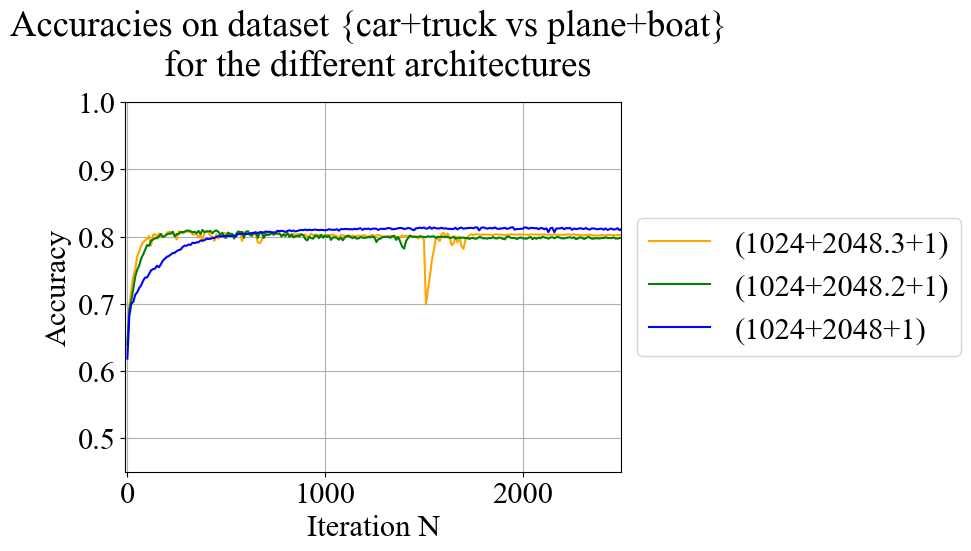

In [20]:
# Import model and plot performances

date = '26_05_25'
save_path = 'Post-processing/27-05-25/Accuracies_of_models/Dataset-car_truck-plane_boat/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(1024+2048+1)_ct-pb"
model_name_2 = "CINIC10_torch_model_(1024+2048.2+1)_ct-pb"
model_name_3 = "CINIC10_torch_model_(1024+2048.3+1)_ct-pb"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'orange', label = '(1024+2048.3+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(1024+2048.2+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(1024+2048+1)')

plt.xlim(-10,2500)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car+truck vs plane+boat} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck-plane_boat_2048h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck-plane_boat_2048h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


FileNotFoundError: [Errno 2] No such file or directory: 'Post-processing/27-05-25/Accuracies_of_models/Dataset-car_truck/Comparison_accuracy_dataset_fully_trained-car_truck_2048h.png'

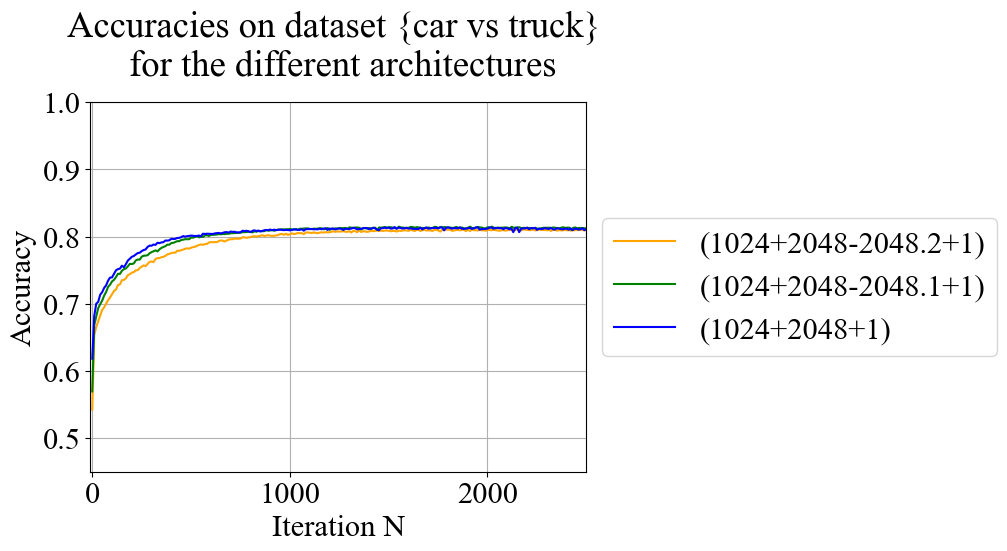

In [14]:
# Import model and plot performances

date = '26_05_25'
save_path = 'Post-processing/27-05-25/Accuracies_of_models/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(1024+2048+1)_ct-pb"
model_name_2 = "CINIC10_torch_model_(1024+2048-2048.1+1)_ct-pb"
model_name_3 = "CINIC10_torch_model_(1024+2048-2048.2+1)_ct-pb"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'orange', label = '(1024+2048-2048.2+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(1024+2048-2048.1+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(1024+2048+1)')

plt.xlim(-10,2500)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car vs truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_2048h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_2048h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


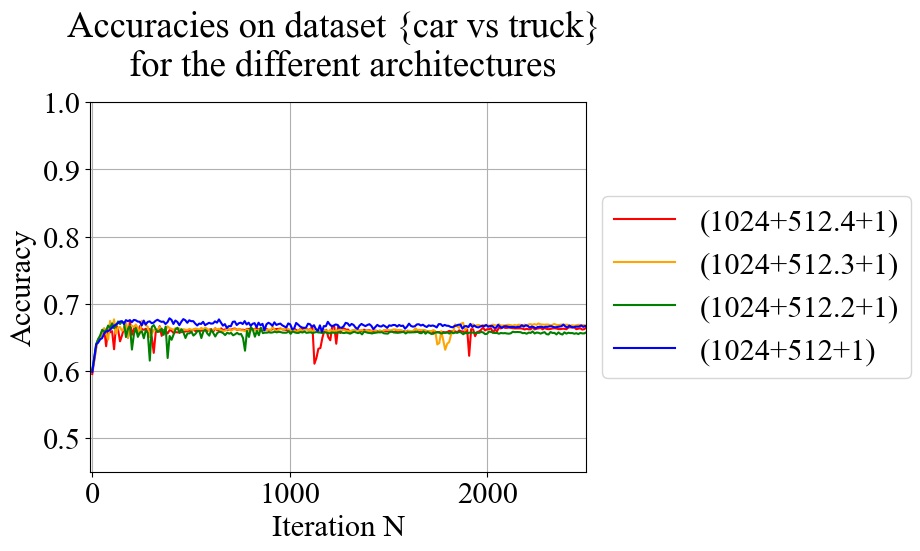

In [ ]:
# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Accuracies_of_models/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(1024+512+1)_ct"
model_name_2 = "CINIC10_torch_model_(1024+512.2+1)_ct"
model_name_3 = "CINIC10_torch_model_(1024+512.3+1)_ct"
model_name_4 = "CINIC10_torch_model_(1024+512.4+1)_ct"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/accuracy_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_4[:, 0], curve_model_4[:, 1], color = 'red', label = '(1024+512.4+1)')
plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'orange', label = '(1024+512.3+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(1024+512.2+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(1024+512+1)')

plt.xlim(-10,2500)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car vs truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_512h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_512h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


In [10]:

# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Overfitting_dynamics/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(1024+512+1)_ct"
model_name_2 = "CINIC10_torch_model_(1024+512.2+1)_ct"
model_name_3 = "CINIC10_torch_model_(1024+512.3+1)_ct"
model_name_4 = "CINIC10_torch_model_(1024+512.4+1)_ct"

curve_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

curve_VL_model_1 =  np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/validation_loss_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'red', label = 'VL_(1024+512.4+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'orange', label = 'VL_(1024+512.3+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(1024+512.2+1)')
plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(1024+512+1)')

plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], color = 'red', label = 'TL_(1024+512.4+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], color = 'orange', label = 'TL_(1024+512.3+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], color = 'green', label = 'TL_(1024+512.2+1)')
plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], color = 'blue', label = 'TL_(1024+512+1)')


plt.xlim(-10,2500)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset {car+truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_fully_trained_dataset_{car+truck}_512h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynamic_fully_trained_dataset_{car+truck}_512h.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


NameError: name 'lower_envelope' is not defined

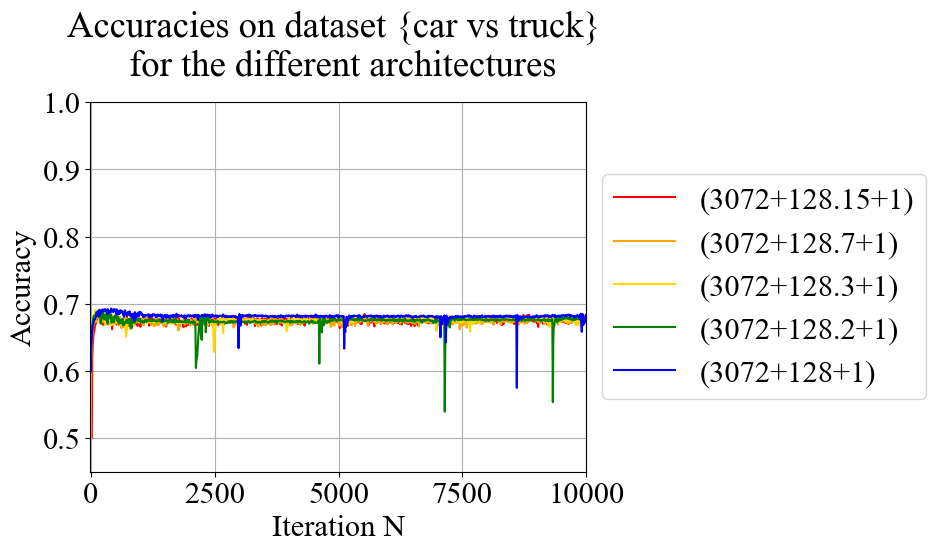

In [11]:
# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Accuracies_of_models/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+128+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+128.2+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+128.3+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+128.7+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+128.15+1)_ct"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/accuracy_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/accuracy_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_5[:, 0], curve_model_5[:, 1], color = 'red', label = '(3072+128.15+1)')
plt.plot(curve_model_4[:, 0], curve_model_4[:, 1], color = 'orange', label = '(3072+128.7+1)')
plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'gold', label = '(3072+128.3+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(3072+128.2+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(3072+128+1)')

plt.xlim(-10,10000)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car vs truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_128h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_128h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


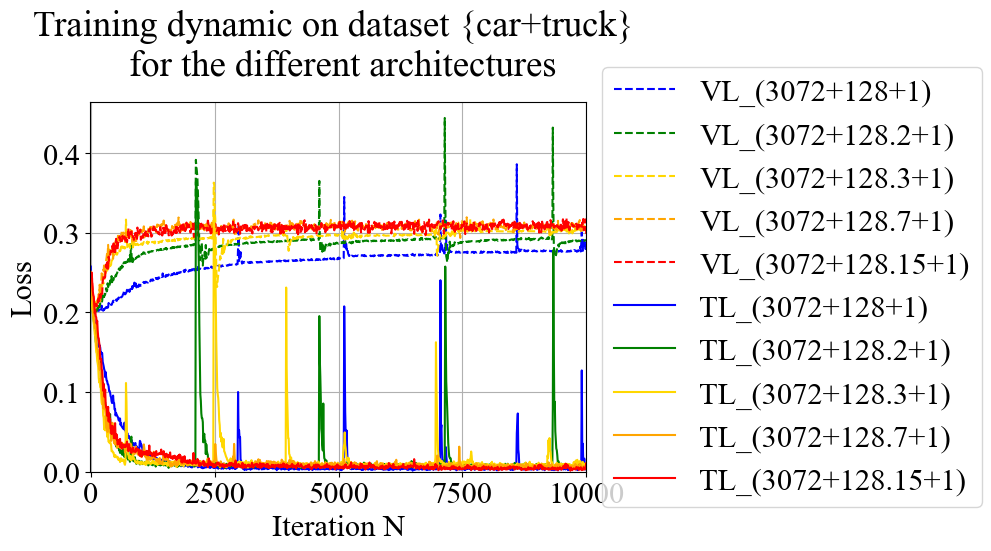

In [12]:

# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Overfitting_dynamics/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+128+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+128.2+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+128.3+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+128.7+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+128.15+1)_ct"

curve_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/loss_training_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

curve_VL_model_1 =  np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/validation_loss_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/validation_loss_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
# curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
# curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
# curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
# curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

# curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
# curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
# curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
# curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(3072+128+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(3072+128.2+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'gold', label = 'VL_(3072+128.3+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'orange', label = 'VL_(3072+128.7+1)')
plt.plot(curve_VL_model_5[:, 0], curve_VL_model_5[:, 1],'--', color = 'red', label = 'VL_(3072+128.15+1)')


plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], color = 'blue', label = 'TL_(3072+128+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], color = 'green', label = 'TL_(3072+128.2+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], color = 'gold', label = 'TL_(3072+128.3+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], color = 'orange', label = 'TL_(3072+128.7+1)')
plt.plot(curve_TL_model_5[:, 0], curve_TL_model_5[:, 1], color = 'red', label = 'TL_(3072+128.15+1)')

plt.xlim(-10,10000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset {car+truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_fully_trained_dataset_{car+truck}_128h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynamic_fully_trained_dataset_{car+truck}_128h.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


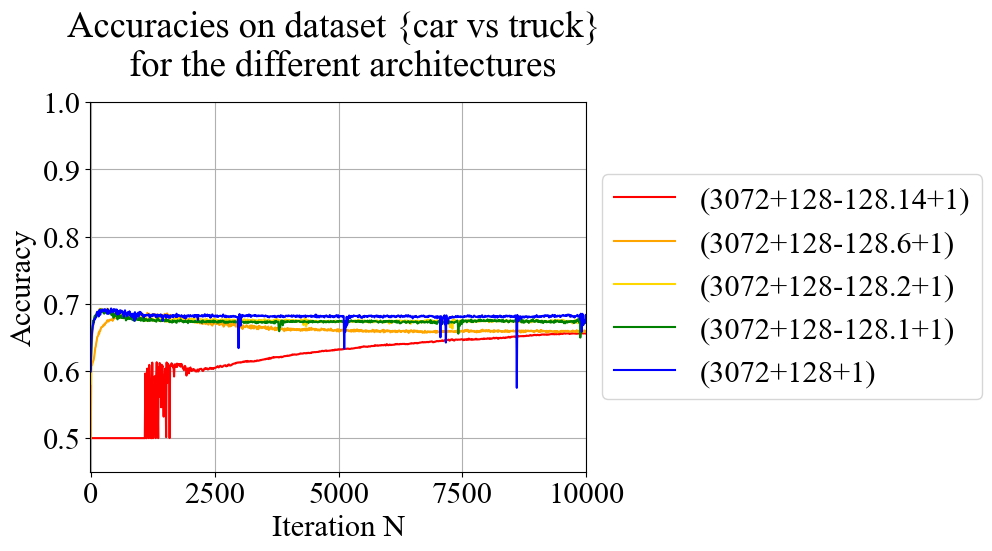

In [13]:
# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Accuracies_of_models/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+128+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+128-128.1+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+128-128.2+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+128-128.6+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+128-128.14+1)_ct"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/accuracy_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/accuracy_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_5[:, 0], curve_model_5[:, 1], color = 'red', label = '(3072+128-128.14+1)')
plt.plot(curve_model_4[:, 0], curve_model_4[:, 1], color = 'orange', label = '(3072+128-128.6+1)')
plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'gold', label = '(3072+128-128.2+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(3072+128-128.1+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(3072+128+1)')

plt.xlim(-10,10000)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car vs truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_extreme_trained-car_truck_128h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_extreme_trained-car_truck_128h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


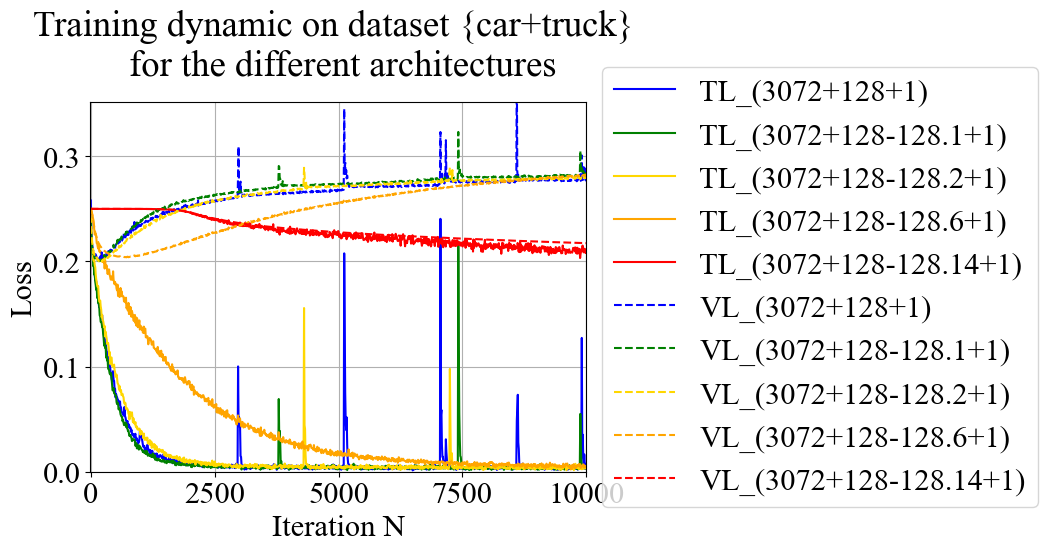

In [14]:

# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Overfitting_dynamics/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+128+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+128-128.1+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+128-128.2+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+128-128.6+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+128-128.14+1)_ct"

curve_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/loss_training_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

curve_VL_model_1 =  np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/validation_loss_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/validation_loss_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
# curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
# curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
# curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
# curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

# curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
# curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
# curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
# curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], color = 'blue', label = 'TL_(3072+128+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], color = 'green', label = 'TL_(3072+128-128.1+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], color = 'gold', label = 'TL_(3072+128-128.2+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], color = 'orange', label = 'TL_(3072+128-128.6+1)')
plt.plot(curve_TL_model_5[:, 0], curve_TL_model_5[:, 1], color = 'red', label = 'TL_(3072+128-128.14+1)')

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(3072+128+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(3072+128-128.1+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'gold', label = 'VL_(3072+128-128.2+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'orange', label = 'VL_(3072+128-128.6+1)')
plt.plot(curve_VL_model_5[:, 0], curve_VL_model_5[:, 1],'--', color = 'red', label = 'VL_(3072+128-128.14+1)')



plt.xlim(-10,10000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset {car+truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_extreme_trained_dataset_{car+truck}_128h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynamic_extreme_trained_dataset_{car+truck}_128h.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


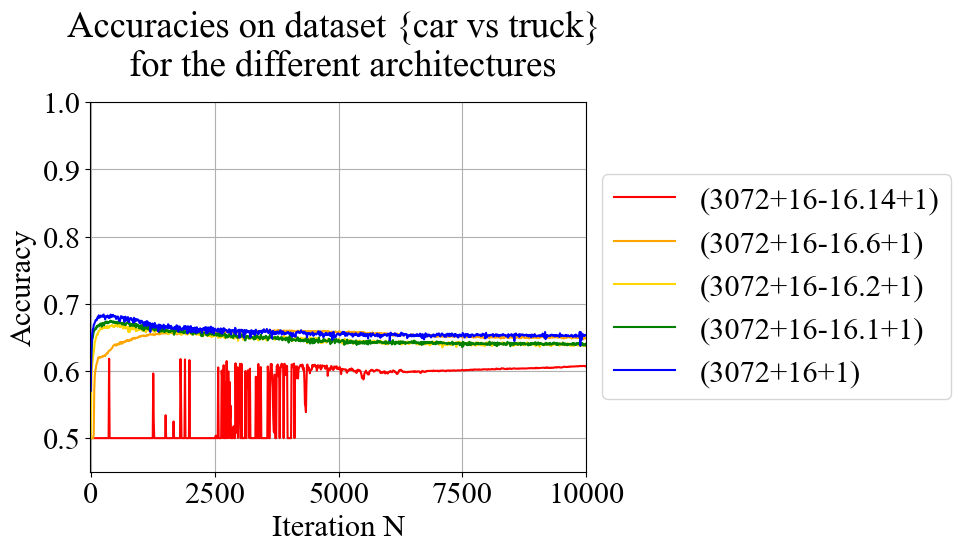

In [15]:
# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Accuracies_of_models/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+16+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+16-16.1+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+16-16.2+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+16-16.6+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+16-16.14+1)_ct"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/accuracy_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/accuracy_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_5[:, 0], curve_model_5[:, 1], color = 'red', label = '(3072+16-16.14+1)')
plt.plot(curve_model_4[:, 0], curve_model_4[:, 1], color = 'orange', label = '(3072+16-16.6+1)')
plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'gold', label = '(3072+16-16.2+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(3072+16-16.1+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(3072+16+1)')

plt.xlim(-10,10000)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car vs truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_extreme_trained-car_truck_16h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_extreme_trained-car_truck_16h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


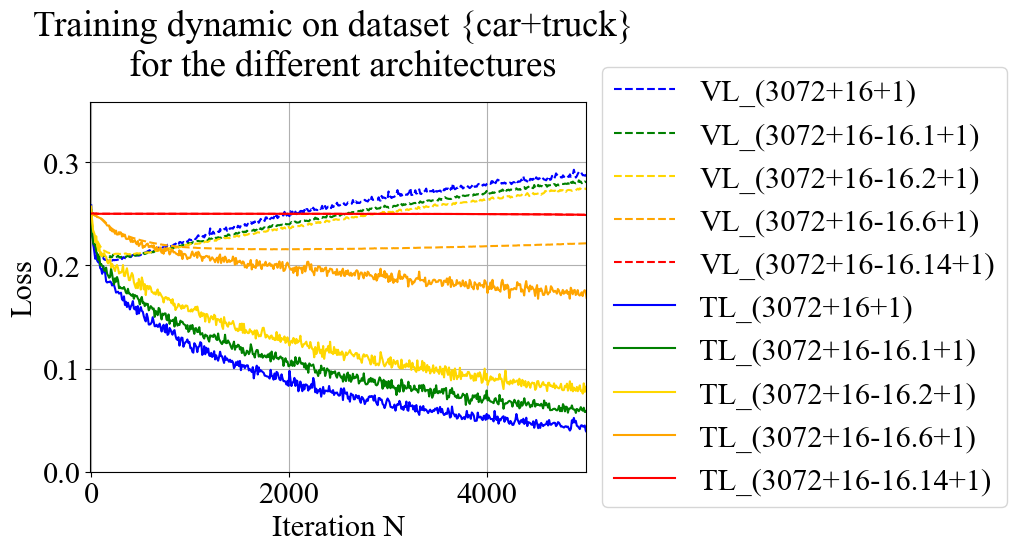

In [16]:

# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Overfitting_dynamics/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+16+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+16-16.1+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+16-16.2+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+16-16.6+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+16-16.14+1)_ct"

curve_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/loss_training_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

curve_VL_model_1 =  np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/validation_loss_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/validation_loss_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
# curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
# curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
# curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
# curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

# curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
# curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
# curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
# curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(3072+16+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(3072+16-16.1+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'gold', label = 'VL_(3072+16-16.2+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'orange', label = 'VL_(3072+16-16.6+1)')
plt.plot(curve_VL_model_5[:, 0], curve_VL_model_5[:, 1],'--', color = 'red', label = 'VL_(3072+16-16.14+1)')

plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], color = 'blue', label = 'TL_(3072+16+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], color = 'green', label = 'TL_(3072+16-16.1+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], color = 'gold', label = 'TL_(3072+16-16.2+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], color = 'orange', label = 'TL_(3072+16-16.6+1)')
plt.plot(curve_TL_model_5[:, 0], curve_TL_model_5[:, 1], color = 'red', label = 'TL_(3072+16-16.14+1)')

plt.xlim(-10,5000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset {car+truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_extreme_trained_dataset_{car+truck}_16h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynamic_extreme_trained_dataset_{car+truck}_16h.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


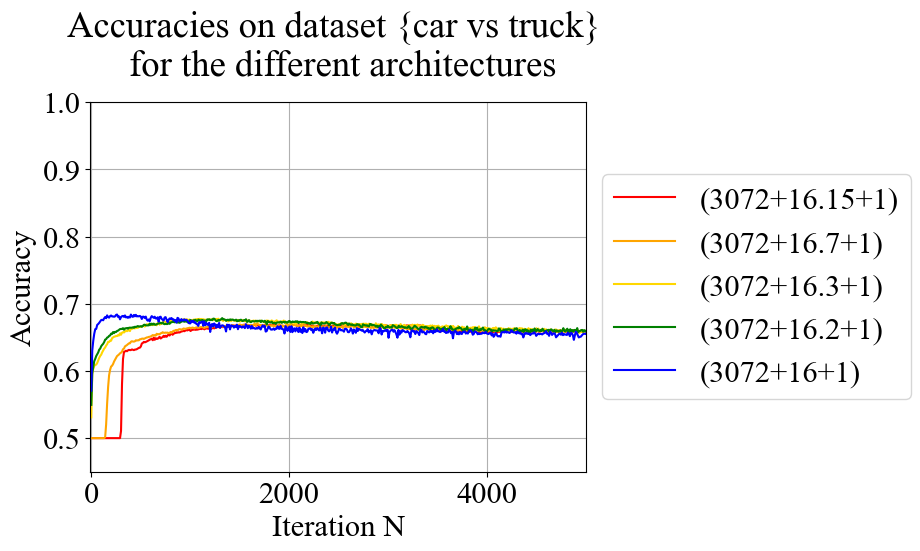

In [17]:
# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Accuracies_of_models/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+16+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+16.2+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+16.3+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+16.7+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+16.15+1)_ct"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/accuracy_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/accuracy_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

# curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
# curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
# curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
# curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])
# curve_model_5 = upper_envelope(curve_model_5[:, 0], curve_model_5[:, 1])

plt.plot(curve_model_5[:, 0], curve_model_5[:, 1], color = 'red', label = '(3072+16.15+1)')
plt.plot(curve_model_4[:, 0], curve_model_4[:, 1], color = 'orange', label = '(3072+16.7+1)')
plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], color = 'gold', label = '(3072+16.3+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], color = 'green', label = '(3072+16.2+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], color = 'blue', label = '(3072+16+1)')

plt.xlim(-10,5000)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset {car vs truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_16h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_accuracy_dataset_fully_trained-car_truck_16h.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


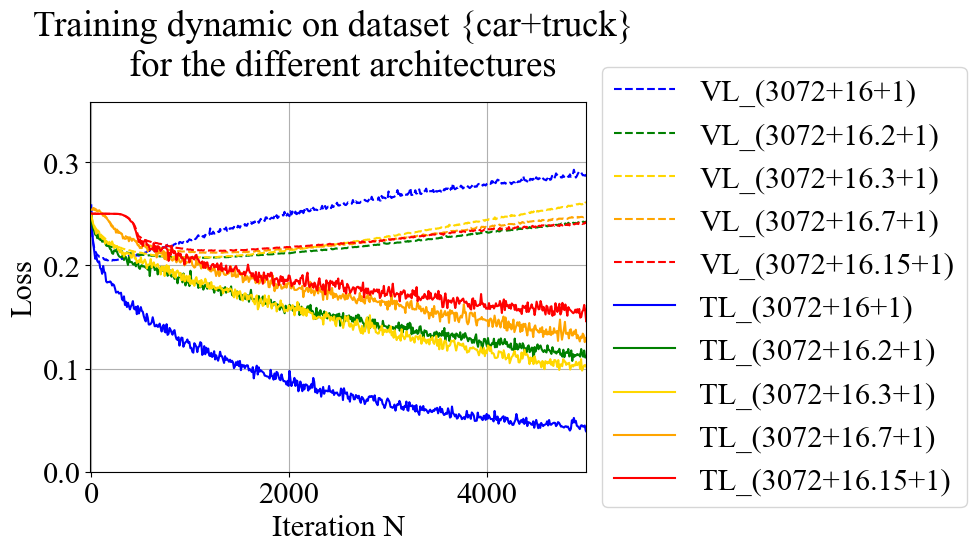

In [18]:

# Import model and plot performances

date = '21_05_25'
save_path = 'Post-processing/21-05-25/Overfitting_dynamics/Dataset-car_truck/'

# Plot the performances
model_name_1 = "CINIC10_torch_model_(3072+16+1)_ct"
model_name_2 = "CINIC10_torch_model_(3072+16.2+1)_ct"
model_name_3 = "CINIC10_torch_model_(3072+16.3+1)_ct"
model_name_4 = "CINIC10_torch_model_(3072+16.7+1)_ct"
model_name_5 = "CINIC10_torch_model_(3072+16.15+1)_ct"

curve_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/loss_training_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)

curve_VL_model_1 =  np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/validation_loss_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_5 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_5 + '/figures/validation_loss_of_' + date + '_' + model_name_5 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
# curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
# curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
# curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
# curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

# curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
# curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
# curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
# curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(3072+16+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(3072+16.2+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'gold', label = 'VL_(3072+16.3+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'orange', label = 'VL_(3072+16.7+1)')
plt.plot(curve_VL_model_5[:, 0], curve_VL_model_5[:, 1],'--', color = 'red', label = 'VL_(3072+16.15+1)')

plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], color = 'blue', label = 'TL_(3072+16+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], color = 'green', label = 'TL_(3072+16.2+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], color = 'gold', label = 'TL_(3072+16.3+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], color = 'orange', label = 'TL_(3072+16.7+1)')
plt.plot(curve_TL_model_5[:, 0], curve_TL_model_5[:, 1], color = 'red', label = 'TL_(3072+16.15+1)')

plt.xlim(-10,5000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset {car+truck} \n for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_fully_trained_dataset_{car+truck}_16h.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynamic_fully_trained_dataset_{car+truck}_16h.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


In [19]:
# Import model and plot performances

date = '13_05_25'
save_path = 'Post-processing/13_05_25/Accuracies_of_models/Dataset_2_ctpb/'

# Plot the performances
model_name_1 = "CIFAR10_model_(1024+512+1)_2_ctpb"
model_name_2 = "CIFAR10_model_(1024+512+512+1)_2_ctpb"
model_name_3 = "CIFAR10_model_(1024+512+512+512+1)_2_ctpb"
model_name_4 = "CIFAR10_model_(1024+512+512+512+512+1)_2_ctpb"

curve_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/accuracy_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

curve_model_1 = upper_envelope(curve_model_1[:, 0], curve_model_1[:, 1])
curve_model_2 = upper_envelope(curve_model_2[:, 0], curve_model_2[:, 1])
curve_model_3 = upper_envelope(curve_model_3[:, 0], curve_model_3[:, 1])
curve_model_4 = upper_envelope(curve_model_4[:, 0], curve_model_4[:, 1])

plt.plot(curve_model_4[:, 0], curve_model_4[:, 1], '.', markersize = '2', color = 'red', label = '(1024+512+512+512+512+1)')
plt.plot(curve_model_3[:, 0], curve_model_3[:, 1], '.', markersize = '2', color = 'orange', label = '(1024+512+512+512+1)')
plt.plot(curve_model_2[:, 0], curve_model_2[:, 1], '.', markersize = '2', color = 'green', label = '(1024+512+512+1)')
plt.plot(curve_model_1[:, 0], curve_model_1[:, 1], '.', markersize = '2', color = 'blue', label = '(1024+512+1)')

plt.xlim(-200,22000)
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset 2_ctpb for the different architectures', pad = 20)
legend = plt.legend()
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_2_ctpb.png", bbox_inches='tight')
plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_2_ctpb.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


FileNotFoundError: Classifiers/13_05_25/13_05_25_CIFAR10_model_(1024+512+1)_2_ctpb/figures/accuracy_of_13_05_25_CIFAR10_model_(1024+512+1)_2_ctpb.txt not found.

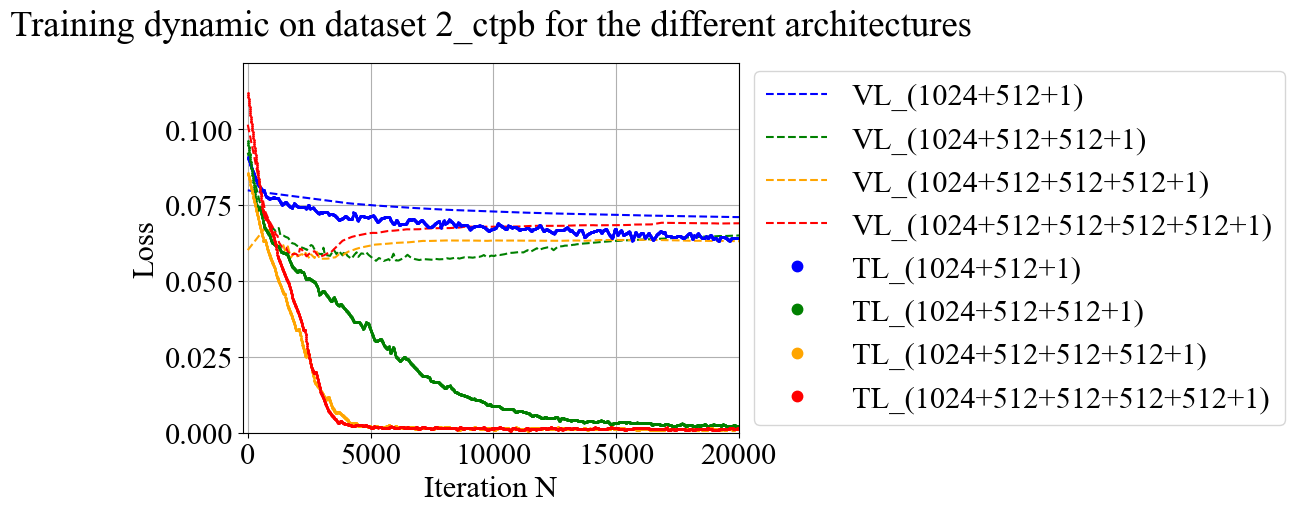

In [43]:

# Import model and plot performances

date = '13_05_25'
save_path = 'Post-processing/13_05_25/Overfitting_dynamic/Dataset_2_ctpb/'

# Plot the performances
model_name_1 = "CIFAR10_model_(1024+512+1)_2_ctpb"
model_name_2 = "CIFAR10_model_(1024+512+512+1)_2_ctpb"
model_name_3 = "CIFAR10_model_(1024+512+512+512+1)_2_ctpb"
model_name_4 = "CIFAR10_model_(1024+512+512+512+512+1)_2_ctpb"

curve_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)


curve_VL_model_1 =  np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/validation_loss_of_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(1024+512+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(1024+512+512+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'orange', label = 'VL_(1024+512+512+512+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'red', label = 'VL_(1024+512+512+512+512+1)')

plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], '.', markersize = '2', color = 'blue', label = 'TL_(1024+512+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], '.', markersize = '2', color = 'green', label = 'TL_(1024+512+512+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], '.', markersize = '2', color = 'orange', label = 'TL_(1024+512+512+512+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], '.', markersize = '2', color = 'red', label = 'TL_(1024+512+512+512+512+1)')

plt.xlim(-200,20000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.01)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset 2_ctpb for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_dataset_2_ctpb.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynammic_dataset_2_ctpb.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


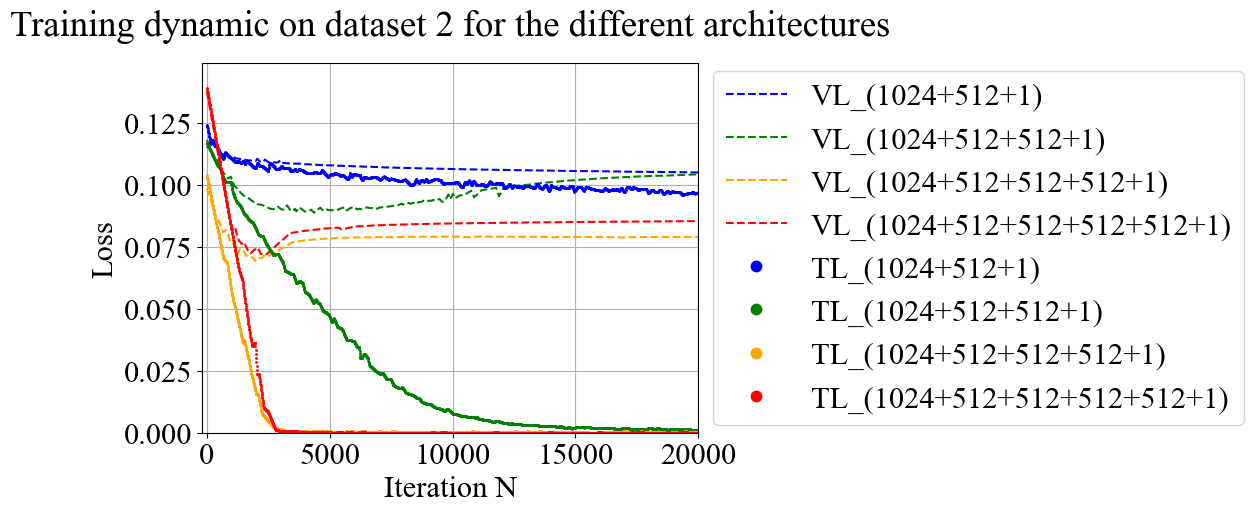

In [44]:

# Import model and plot performances

date = '13_05_25'
save_path = 'Post-processing/13_05_25/Overfitting_dynamic/Dataset_2/'

# Plot the performances
model_name_1 = "CIFAR10_model_(1024+512+1)_2"
model_name_2 = "CIFAR10_model_(1024+512+512+1)_2"
model_name_3 = "CIFAR10_model_(1024+512+512+512+1)_2"
model_name_4 = "CIFAR10_model_(1024+512+512+512+512+1)_2"

curve_x_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_y_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/kappa_loss_training_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_1 = np.concatenate((curve_x_TL_model_1[:,0].reshape(-1,1), curve_y_TL_model_1[:,1].reshape(-1,1)), axis=1)

curve_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)


curve_x_VL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_y_VL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/kappa_loss_validation_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_1 = np.concatenate((curve_x_VL_model_1[:,0].reshape(-1,1), curve_y_VL_model_1[:,1].reshape(-1,1)), axis=1)

curve_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/validation_loss_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/validation_loss_of_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/validation_loss_of_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)


# Extracting the lower envelope
curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(1024+512+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(1024+512+512+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'orange', label = 'VL_(1024+512+512+512+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'red', label = 'VL_(1024+512+512+512+512+1)')

plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], '.', markersize = '2', color = 'blue', label = 'TL_(1024+512+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], '.', markersize = '2', color = 'green', label = 'TL_(1024+512+512+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], '.', markersize = '2', color = 'orange', label = 'TL_(1024+512+512+512+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], '.', markersize = '2', color = 'red', label = 'TL_(1024+512+512+512+512+1)')

plt.xlim(-200,20000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.01)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset 2 for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_dataset_2.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynammic_dataset_2.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


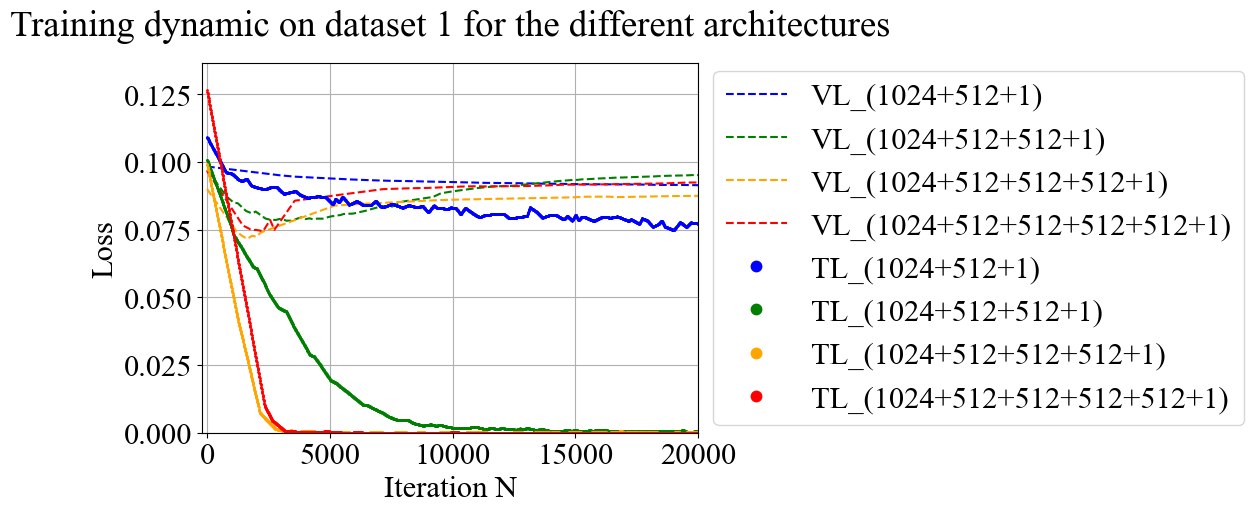

In [20]:

# Import model and plot performances

date = '13_05_25'
save_path = 'Post-processing/13_05_25/Overfitting_dynamic/Dataset_1/'

# Plot the performances
model_name_1 = "CIFAR10_model_(1024+512+1)_1"
model_name_2 = "CIFAR10_model_(1024+512+512+1)_1"
model_name_3 = "CIFAR10_model_(1024+512+512+512+1)_1"
model_name_4 = "CIFAR10_model_(1024+512+512+512+512+1)_1"

curve_y_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/kappa_loss_training_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_y_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/kappa_loss_training_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_y_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/kappa_loss_training_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_y_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/kappa_loss_training_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

curve_x_TL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_x_TL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_x_TL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_x_TL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

curve_TL_model_1 = np.concatenate((curve_x_TL_model_1[:,0].reshape(-1,1), curve_y_TL_model_1[:,1].reshape(-1,1)), axis=1)
curve_TL_model_2 = np.concatenate((curve_x_TL_model_2[:,0].reshape(-1,1), curve_y_TL_model_2[:,1].reshape(-1,1)), axis=1)
curve_TL_model_3 = np.concatenate((curve_x_TL_model_3[:,0].reshape(-1,1), curve_y_TL_model_3[:,1].reshape(-1,1)), axis=1)
curve_TL_model_4 = np.concatenate((curve_x_TL_model_4[:,0].reshape(-1,1), curve_y_TL_model_4[:,1].reshape(-1,1)), axis=1)

curve_y_VL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/kappa_loss_validation_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_y_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/kappa_loss_validation_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_y_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/kappa_loss_validation_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_y_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/kappa_loss_validation_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

curve_x_VL_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/loss_training_' + date + '_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_x_VL_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/loss_training_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_x_VL_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/loss_training_' + date + '_' + model_name_3 +'.txt', delimiter=",", skiprows=1)
curve_x_VL_model_4 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_4 + '/figures/loss_training_' + date + '_' + model_name_4 +'.txt', delimiter=",", skiprows=1)

curve_VL_model_1 = np.concatenate((curve_x_VL_model_1[:,0].reshape(-1,1), curve_y_VL_model_1[:,1].reshape(-1,1)), axis=1)
curve_VL_model_2 = np.concatenate((curve_x_VL_model_2[:,0].reshape(-1,1), curve_y_VL_model_2[:,1].reshape(-1,1)), axis=1)
curve_VL_model_3 = np.concatenate((curve_x_VL_model_3[:,0].reshape(-1,1), curve_y_VL_model_3[:,1].reshape(-1,1)), axis=1)
curve_VL_model_4 = np.concatenate((curve_x_VL_model_4[:,0].reshape(-1,1), curve_y_VL_model_4[:,1].reshape(-1,1)), axis=1)

# Extracting the lower envelope
curve_VL_model_1 = lower_envelope(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1])
curve_VL_model_2 = lower_envelope(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1])
curve_VL_model_3 = lower_envelope(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1])
curve_VL_model_4 = lower_envelope(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1])

curve_TL_model_1 = lower_envelope(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1])
curve_TL_model_2 = lower_envelope(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1])
curve_TL_model_3 = lower_envelope(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1])
curve_TL_model_4 = lower_envelope(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1])

plt.plot(curve_VL_model_1[:, 0], curve_VL_model_1[:, 1],'--', color = 'blue', label = 'VL_(1024+512+1)')
plt.plot(curve_VL_model_2[:, 0], curve_VL_model_2[:, 1],'--', color = 'green', label = 'VL_(1024+512+512+1)')
plt.plot(curve_VL_model_3[:, 0], curve_VL_model_3[:, 1],'--', color = 'orange', label = 'VL_(1024+512+512+512+1)')
plt.plot(curve_VL_model_4[:, 0], curve_VL_model_4[:, 1],'--', color = 'red', label = 'VL_(1024+512+512+512+512+1)')

plt.plot(curve_TL_model_1[:, 0], curve_TL_model_1[:, 1], '.', markersize = '2', color = 'blue', label = 'TL_(1024+512+1)')
plt.plot(curve_TL_model_2[:, 0], curve_TL_model_2[:, 1], '.', markersize = '2', color = 'green', label = 'TL_(1024+512+512+1)')
plt.plot(curve_TL_model_3[:, 0], curve_TL_model_3[:, 1], '.', markersize = '2', color = 'orange', label = 'TL_(1024+512+512+512+1)')
plt.plot(curve_TL_model_4[:, 0], curve_TL_model_4[:, 1], '.', markersize = '2', color = 'red', label = 'TL_(1024+512+512+512+512+1)')

plt.xlim(-200,20000)
plt.ylim(0,np.max([np.max(curve_TL_model_4[:, 1]), np.max(curve_TL_model_3[:, 1]), np.max(curve_TL_model_2[:, 1]), np.max(curve_TL_model_1[:, 1])]) + 0.01)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Loss')
plt.title('Training dynamic on dataset 1 for the different architectures', pad = 20)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in legend.legend_handles:
    handle.set_markersize(15)   
plt.savefig(save_path + "Comparison_overfitting_dynamic_dataset_1.png", bbox_inches='tight')
plt.savefig(save_path + "Comparison_overfitting_dynammic_dataset_1.svg", bbox_inches='tight')
plt.show()

# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
# plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
# plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


2 layers - Training first layer : True - Training second layer : True - kappa = 2.45 - lr = 1e-05 - lr_decay_rate = 100000000.0 - reg1 = 0 - reg2 = 0 - eps_init = 1 - fraction_batch = 0.2 - observation rate = 10 - Train layer 1 = True - Train layer 2 = True - Dropout rate = 0.4
[0.         0.48416665]


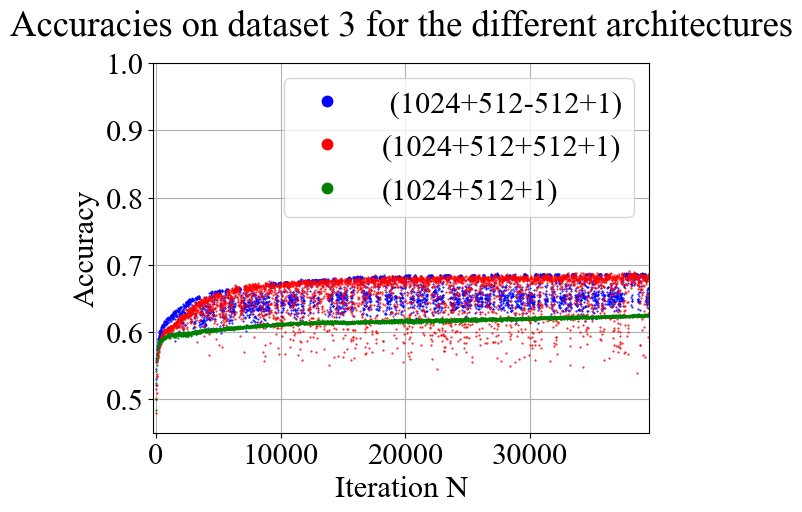

In [10]:
# Import model and plot performances

date = '07_05_25'
model_name = "CIFAR10_model_(1024+512+1)_save_3"
curve_datas = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name + '/figures/accuracy_of_' + model_name +'.txt', delimiter=",", skiprows=1)
assessed_model = torch.load('Classifiers/' + date + '/' + date + '_' +  model_name + '/' + model_name + ".pt", weights_only=False)
save_path = 'Post-processing/08_05_25/Dataset_3/'
# Details of the model
print(assessed_model.architecture)

# Plot the performances
model_name_1 = "CIFAR10_model_(1024+512+1)_3"
model_name_2 = "CIFAR10_model_(1024+512+512+1)_3"
model_name_3 = "CIFAR10_model_(1024+512-512+1)_3"

curve_datas_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_datas_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_datas_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + model_name_3 +'.txt', delimiter=",", skiprows=1)

print(curve_datas_model_1[0])
plt.plot(curve_datas_model_3[:, 0], curve_datas_model_3[:, 1], '.', markersize = '1', color = 'blue', label = ' (1024+512-512+1)')
plt.plot(curve_datas_model_2[:, 0], curve_datas_model_2[:, 1], '.', markersize = '1', color = 'red', label = '(1024+512+512+1)')
plt.plot(curve_datas_model_1[:, 0], curve_datas_model_1[:, 1], '.', markersize = '1', color = 'green', label = '(1024+512+1)')
plt.xlim(-200,np.min([np.max(curve_datas_model_1[:, 0]), np.max(curve_datas_model_2[:, 0]), np.max(curve_datas_model_3[:, 0])]))
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset 3 for the different architectures', pad = 20)
legend = plt.legend()
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
